In [17]:
%matplotlib inline

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.covariance import EmpiricalCovariance
from sklearn.pipeline import Pipeline

In [19]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [20]:
# remove zero var columns
zero_var_cols = []
for col in df_train.columns:
    if df_train[col].var() == 0:
        zero_var_cols.append(col)
        
print 'Columns with zero variance'
print zero_var_cols

df_train = df_train.drop(zero_var_cols, axis=1)
df_test = df_test.drop(zero_var_cols, axis=1)

Columns with zero variance
['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3', 'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo_var2_ult1', 'saldo_medio_var13_medio_hace3']


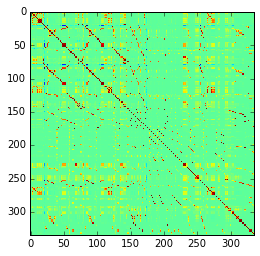

In [21]:
# column correlations
r = df_train.drop(['TARGET', 'ID'], axis=1).corr()
plt.imshow(r, interpolation='nearest')

In [32]:
# drop perfectly correlated columns
corr_columns = []
r_thresh = 1.0

for i in range(r.shape[0]-1):
    for j in range(i+1, r.shape[1]):
        if r.iloc[i, j] >= r_thresh:
            corr_columns.append(r.columns[j])
    
print 'Columns with r >= %f' % r_thresh
print corr_columns

df_train = df_train.drop(corr_columns, axis=1)
df_test = df_test.drop(corr_columns, axis=1)

Columns with r >= 1.000000
['ind_var29_0', 'ind_var29', 'num_var6', 'num_var29', 'ind_var13_medio', 'num_var13_medio_0', 'num_var13_medio', 'num_meses_var13_medio_ult3', 'num_var13_medio_0', 'num_var13_medio', 'num_meses_var13_medio_ult3', 'ind_var18', 'num_var18_0', 'num_var18', 'num_var18_0', 'num_var18', 'num_var20_0', 'num_var20', 'ind_var26', 'ind_var25', 'num_var6', 'num_var29', 'ind_var32', 'ind_var34', 'ind_var37', 'ind_var39', 'num_var29_0', 'num_var29', 'num_var13_medio', 'num_meses_var13_medio_ult3', 'num_meses_var13_medio_ult3', 'num_var18', 'delta_imp_amort_var18_1y3', 'delta_imp_amort_var18_1y3', 'num_var26', 'num_var25', 'num_var32', 'num_var34', 'delta_imp_amort_var34_1y3', 'delta_imp_amort_var34_1y3', 'num_var37', 'num_var39', 'saldo_var29', 'saldo_medio_var13_medio_ult1', 'delta_num_aport_var13_1y3', 'delta_num_aport_var17_1y3', 'delta_num_aport_var33_1y3', 'delta_num_reemb_var13_1y3', 'num_reemb_var13_ult1', 'delta_num_reemb_var17_1y3', 'delta_num_reemb_var33_1y3', '

ValueError: labels ['ind_var29_0' 'ind_var29' 'num_var6' 'num_var29' 'ind_var13_medio'
 'num_var13_medio_0' 'num_var13_medio' 'num_meses_var13_medio_ult3'
 'num_var13_medio_0' 'num_var13_medio' 'num_meses_var13_medio_ult3'
 'ind_var18' 'num_var18_0' 'num_var18' 'num_var18_0' 'num_var18'
 'num_var20_0' 'num_var20' 'ind_var26' 'ind_var25' 'num_var6' 'num_var29'
 'ind_var32' 'ind_var34' 'ind_var37' 'ind_var39' 'num_var29_0' 'num_var29'
 'num_var13_medio' 'num_meses_var13_medio_ult3'
 'num_meses_var13_medio_ult3' 'num_var18' 'delta_imp_amort_var18_1y3'
 'delta_imp_amort_var18_1y3' 'num_var26' 'num_var25' 'num_var32'
 'num_var34' 'delta_imp_amort_var34_1y3' 'delta_imp_amort_var34_1y3'
 'num_var37' 'num_var39' 'saldo_var29' 'saldo_medio_var13_medio_ult1'
 'delta_num_aport_var13_1y3' 'delta_num_aport_var17_1y3'
 'delta_num_aport_var33_1y3' 'delta_num_reemb_var13_1y3'
 'num_reemb_var13_ult1' 'delta_num_reemb_var17_1y3'
 'delta_num_reemb_var33_1y3' 'num_reemb_var33_ult1'
 'delta_num_trasp_var17_in_1y3' 'delta_num_trasp_var17_out_1y3'
 'delta_num_trasp_var33_in_1y3' 'delta_num_trasp_var33_out_1y3'
 'num_trasp_var33_out_ult1' 'delta_num_venta_var44_1y3'
 'num_reemb_var13_ult1' 'num_reemb_var33_ult1' 'num_trasp_var33_out_ult1'] not contained in axis

In [23]:
# var3 maybe contains some sort of error code with -999999
descriptive = df_train.describe()
descriptive.loc['unique'] = [len(df_train[col].unique()) for col in df_train.columns]
pd.options.display.max_columns = descriptive.shape[1]
descriptive

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_medio_0,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var25_0,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var33_0,ind_var33,ind_var34_0,ind_var37_cte,ind_var37_0,ind_var39_0,ind_var41_0,ind_var44_0,ind_var44,num_var4,num_var5_0,num_var12_0,num_var13_0,num_var13_largo_0,num_var13_largo,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var26_0,num_var25_0,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var33_0,num_var33,num_var35,num_var37_med_ult2,num_var37_0,num_var39_0,num_var41_0,num_var42_0,num_var42,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var20,saldo_var26,saldo_var25,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var42,saldo_var44,var36,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_aport_var33_hace3,num_aport_var33_ult1,num_var7_recib_ult1,num_compra_var44_hace3,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var17_ult3,num_meses_var29_ult3,num_meses_var33_ult3,num_meses_var39_vig_ult3,num_meses_var44_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_comer_ult1,num_op_var41_comer_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_reemb_var17_ult1,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_trasp_var33_in_hace3,num_trasp_var33_in_ult1,num_venta_var44_hace3,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_va

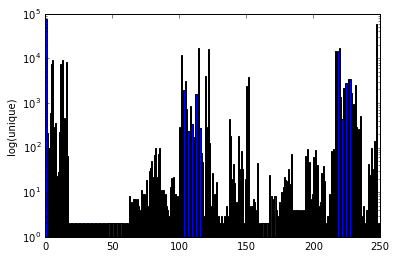

In [24]:
plt.bar(range(len(descriptive.T['unique'])), descriptive.T['unique'])
plt.gca().set_yscale('log')
plt.ylabel('log(unique)')

In [25]:
X_train = df_train.drop(['TARGET', 'ID'], axis=1).values
X_test = df_test.drop(['ID'], axis=1).values
y_train = df_train['TARGET'].values

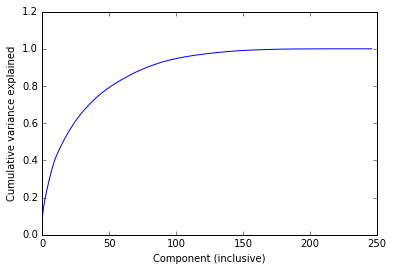

In [26]:
# pca -- seems to be about 100-150 dims
pca = Pipeline([
        ('std', StandardScaler()),
        ('pca', PCA()),
    ])

pca = pca.fit(X_train)
explained_variance_ratio = pca.steps[-1][-1].explained_variance_ratio_

plt.plot(np.cumsum(explained_variance_ratio))
plt.ylabel('Cumulative variance explained')
plt.xlabel('Component (inclusive)')

In [27]:
# pca -- see if loadings make any sense
components = pca.steps[-1][-1].components_
n_components = 5
n_loadings = 5
loadings = ''

for i in range(n_components):
    sort_idx = np.argsort(np.abs(components[i, :]))[::-1][:n_components]
    loadings += 'PC%d: ' % i
    for j in sort_idx:
        loadings += '%.2f*%s + '% (components[i, j], df_train.columns[j])
    loadings += '...\n\n'
print loadings

PC0: 0.17*ind_var44 + 0.17*num_var33 + 0.16*num_op_var39_ult1 + 0.16*num_op_var39_hace3 + 0.16*num_op_var41_ult1 + ...

PC1: -0.21*num_op_var39_ult3 + -0.21*ind_var12 + -0.21*num_var12_0 + -0.21*num_var13_largo + -0.21*ind_var13_medio_0 + ...

PC2: -0.27*ind_var30 + -0.27*ind_var31_0 + -0.25*num_var31_0 + -0.25*num_var30 + -0.19*ind_var17_0 + ...

PC3: -0.23*saldo_var8 + -0.23*saldo_medio_var12_ult1 + -0.23*saldo_medio_var12_hace3 + -0.23*saldo_var40 + -0.23*ind_var24_0 + ...

PC4: -0.22*ind_var25_cte + -0.22*ind_var26_0 + -0.21*ind_var8_0 + -0.21*ind_var26_cte + -0.21*ind_var6 + ...




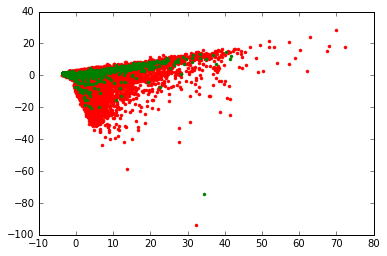

In [28]:
# pca -- see if any separability in projections
unsatisfied = y_train == 0
satisfied = y_train == 1

X_pca = pca.transform(X_train)

plt.plot(X_pca[unsatisfied, 0], X_pca[unsatisfied, 1], 'r.')
plt.plot(X_pca[satisfied, 0], X_pca[satisfied, 1], 'g.')

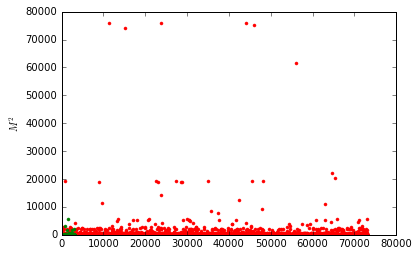

In [29]:
# potential outliers?
ec = EmpiricalCovariance()
ec = ec.fit(X_train)
m2 = ec.mahalanobis(X_train)

plt.plot(m2[unsatisfied], 'r.')
plt.plot(m2[satisfied], 'g.')
plt.ylabel('$M^2$')


Potential outliers 22/76020


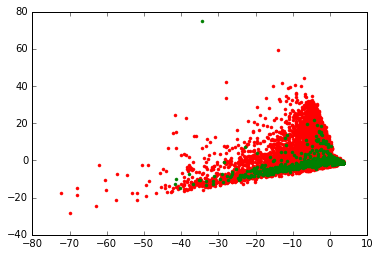

In [30]:
# pca -- rerun without outliers
inliers = m2 < 10000
print 'Potential outliers %d/%d' % (X_train.shape[0]-np.sum(inliers), X_train.shape[0])

X_train_in = X_train[inliers, :]
y_train_in = y_train[inliers]

pca = pca.fit(X_train_in)

unsatisfied = y_train_in == 0
satisfied = y_train_in == 1

X_pca = pca.transform(X_train_in)

plt.plot(X_pca[unsatisfied, 0], X_pca[unsatisfied, 1], 'r.')
plt.plot(X_pca[satisfied, 0], X_pca[satisfied, 1], 'g.')

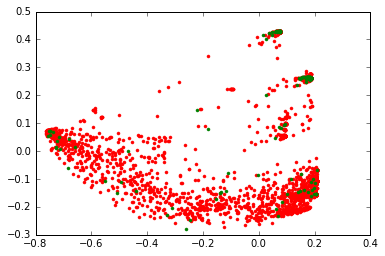

In [31]:
# kpca -- try with a smaller set of data to see if it becomes more easily separable
np.random.seed(0)

sample_pct = 0.05
sample_n = int(sample_pct * X_train.shape[0])
sample_idx = np.random.permutation(range(X_train.shape[0]))[:sample_n]

X_train_sub = X_train[sample_idx, :]
y_train_sub = y_train[sample_idx]

# pca -- seems to be about 100-150 dims
kpca = Pipeline([
        ('std', StandardScaler()),
        ('pca', KernelPCA(kernel='rbf')),
    ])
kpca = kpca.fit(X_train_sub)

unsatisfied = y_train_sub == 0
satisfied = y_train_sub == 1

X_kpca = kpca.transform(X_train_sub)

plt.plot(X_kpca[unsatisfied, 0], X_kpca[unsatisfied, 1], 'r.')
plt.plot(X_kpca[satisfied, 0], X_kpca[satisfied, 1], 'g.')